# Assignment 3: RTRL

Implement an RNN with RTRL. The ds/dw partial derivative is 2D hidden x (self.n_hidden * self.n_input) instead of 3d.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RNN(object):
    def __init__(self, n_input, n_hidden, n_output):
        # init weights and biases
        self.n_input  = n_input 
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        self.W = np.random.normal(scale=0.1, size=(n_hidden, n_input))
        self.R = np.eye(n_hidden)
        self.V = np.random.normal(scale=0.1, size=(n_output, n_hidden))
        self.bh = np.zeros((n_hidden, 1))
        self.bo = np.zeros((n_output, 1))
        
        self.grad = {}
        self.reset()
        
     
    def reset(self):
        # init hidden activation
        self.s = np.zeros((self.n_hidden, 1))
        self.a = np.zeros((self.n_hidden, 1))
        
        # init buffers for recursive gradients
        self.ds_dW = np.zeros((self.n_hidden, self.n_hidden * self.n_input))
        self.ds_dR = np.zeros((self.n_hidden, self.n_hidden * self.n_hidden)) 
        self.ds_db = np.zeros((self.n_hidden, self.n_hidden))
    
    
    def forward(self, x):
        assert x.shape[1] == self.n_input
        assert len(x.shape) == 2

        """your code goes here, method must return model's prediction"""
        # partial derivative for accumulation. this is the R * f' * f that can be reused
        der = self.R * np.tile(1-self.a**2, self.n_hidden)
        
        # accumulate gradients
        self.ds_dW = der @ self.ds_dW + np.kron(np.eye(self.n_hidden), x)
        self.ds_dR = der @ self.ds_dR + np.kron(np.eye(self.n_hidden), self.a.T)
        self.ds_db = der @ self.ds_db +         np.eye(self.n_hidden)
        
        # do regular 1 step forward pass
        self.s = self.W @ x.T + self.R @ self.a + self.bh
        self.a = np.tanh(self.s)  # can be reused in backward pass
        return (self.V @ self.a + self.bo).T
        
    
    def backward(self, y_hat, y):
        assert y_hat.shape[1] == self.n_output
        assert len(y_hat.shape) == 2
        assert y_hat.shape == y.shape, f"shape mismatch {y_hat.shape} {y.shape}"

        e = (y_hat - y).T  # error == derivative{L}/derivative{s} == dL_dy
        dL_ds = ((self.V.T @ e) * (1 - self.a**2))  # transposed to fit shape
        
        # 1:1 copy from ex1, only depend on error
        self.grad["bo"] = e
        self.grad["V"]  = e @ self.a.T
        
        # collect new gradients
        self.grad["W"] = (self.ds_dW.T @ dL_ds).reshape(self.W.shape)
        self.grad["R"] = (self.ds_dR.T @ dL_ds).reshape(self.R.shape).T
        self.grad["bh"]=  self.ds_db.T @ dL_ds
        
        # compute loss (halved squared error)
        return np.sum(0.5 * (y - y_hat)**2)
    
    
    def fast_forward(self, x_seq):
        # this is a forward pass without gradient computation for gradient checking
        s = np.zeros_like(self.s)
        
        for x in x_seq:
            s = self.W @ x.reshape(*x.shape, 1) + self.R.T @ np.tanh(s) + self.bh
        
        return self.V @ np.tanh(s) + self.bo
    
    
    def gradient_check(self, x, y, eps=1e-5, thresh=1e-5, verbose=True):
        for name, ga in self.grad.items():
            if verbose:
                print("weight\t",name)
            
            gn = np.zeros_like(ga)
            w = self.__dict__[name]
            for idx, w_orig in np.ndenumerate(w):
                w[idx] = w_orig + eps/2
                hi = np.sum(0.5 * (y - self.fast_forward(x))**2)
                w[idx] = w_orig - eps/2
                lo = np.sum(0.5 * (y - self.fast_forward(x))**2)
                w[idx] = w_orig
                gn[idx] = (hi - lo) / eps
                dev = abs(gn[idx] - ga[idx])

                if verbose:  # extended error
                    print(f"numeric {gn[idx]}\tanalytic {ga[idx]}\tdeviation {dev}")

                assert dev < thresh

    
    def update(self, eta):
        # update weights
        for name, grad in self.grad.items():
            self.__dict__[name] -= eta * grad


def generate_samples(seq_length, batch_size, input_size):
    while True:
        x = np.random.uniform(low=-1, high=1, size=(seq_length, batch_size, input_size))
        y = x[0,:,:]
        yield x, y


def check_gradients():
    rnn = RNN(2, 5, 2)
    data = generate_samples(seq_length=10, batch_size=1, input_size=2)
    
    for i, (x, y) in zip(range(1), data):
        rnn.reset()
        
        for x_t in x:
            y_hat = rnn.forward(x_t)
        
        rnn.backward(y_hat, y)
        rnn.gradient_check(x, y.T)

check_gradients()

weight	 bo
numeric 0.815833856365744	analytic 0.8158338563577928	deviation 7.951195257760446e-12
numeric 0.22869662842928126	analytic 0.2286966284260183	deviation 3.2629732249489507e-12
weight	 V
numeric -0.06227159701777118	analytic -0.06227159701766642	deviation 1.0475648126728743e-13
numeric -0.20825869057050636	analytic -0.20825869056251206	deviation 7.994299666691518e-12
numeric 0.12911525329450946	analytic 0.12911525329593596	deviation 1.426497808765248e-12
numeric -0.25530579405574905	analytic -0.25530579405855447	deviation 2.805422560925308e-12
numeric 0.2864484471010176	analytic 0.2864484470922884	deviation 8.729184042266525e-12
numeric -0.01745613297798876	analytic -0.017456132978132165	deviation 1.434061203120507e-13
numeric -0.058379607564829065	analytic -0.058379607564577635	deviation 2.514308206080784e-13
numeric 0.03619391727438526	analytic 0.03619391727499229	deviation 6.070352553955161e-13
numeric -0.07156797167118256	analytic -0.07156797166948202	deviation 1.700542484

# Train gradient and plot weights

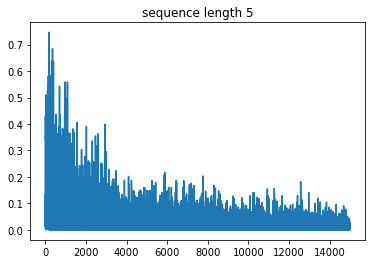

In [3]:
def train():
    iter_steps = 15000
    lr = 1e-2
    seq_length = 5
    
    rnn = RNN(1, 10, 1)
    data = generate_samples(seq_length=seq_length, batch_size=1, input_size=1)
    loss = []

    for i, (x, y) in zip(range(iter_steps), data):
        rnn.reset()

        for x_t in x:
            y_hat = rnn.forward(x_t)

        loss.append(rnn.backward(y_hat, y))
        rnn.update(lr)

    # plot learnin g curve
    plt.title('sequence length %d' % seq_length)
    plt.plot(range(len(loss)), loss)
    plt.show()

train()